In [2]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o", temperature=0)

import nest_asyncio
nest_asyncio.apply()

# State Definition

In [74]:
from typing import TypedDict, List, Annotated
from playwright.async_api import Page
from langchain_core.messages import BaseMessage
from operator import add

class Bbox(TypedDict):
    x: int
    y: int
    text: str
    type: str
    ariaLabel: str

class Action(TypedDict):
    action: str
    args: str | Bbox

class AgentState(TypedDict):
    input: str
    page: Page
    image: str
    bboxes: List[Bbox]
    updated_notes: List[BaseMessage]
    action: Action | str


# ScreenShot and Annotation Helper Functions

In [75]:
import base64
import asyncio
from playwright.async_api import async_playwright
import asyncio
from PIL import Image as PILImage
import io
from playwright.async_api import Page


with open("mark_page.js") as f:
    mark_page_script = f.read()

async def is_image_blank(image_bytes: bytes) -> bool:
    """Return True if the screenshot is fully blank (e.g. all white), else False."""
    if not image_bytes:
        return True
    img = PILImage.open(io.BytesIO(image_bytes)).convert("L")
    # If getbbox() returns None, the image is entirely one color
    return img.getbbox() is None

async def capture_screenshot(page: Page, max_retries=3, wait_seconds=2) -> bytes:
    """Take a screenshot, retry if blank (completely white)."""
    screenshot_bytes = b""
    for attempt in range(max_retries):
        # Wait for the page to be fully loaded
        await page.wait_for_load_state("networkidle")
        
        # Take screenshot
        screenshot_bytes = await page.screenshot(path="screenshot.png")
        
        # Check if it's blank
        if not await is_image_blank(screenshot_bytes):
            return screenshot_bytes
        
        # If blank, wait a bit and retry
        print(f"[capture_screenshot] Screenshot is blank (attempt {attempt+1}/{max_retries}). Retrying...")
        await asyncio.sleep(wait_seconds)
    
    # If we get here, all attempts yielded a blank screenshot
    print("[capture_screenshot] All screenshot attempts were blank.")
    return screenshot_bytes  # Return whatever we got last


async def mark_page(page):

    """
    1. Wait for the page to be loaded using 'networkidle'.
    2. Attempt to run a 'mark_page_script' that presumably marks and returns bounding boxes.
    3. Retry up to 10 times if it fails.
    4. Capture a screenshot with retry logic (up to 3 tries) if the page is blank.
    5. Process screenshot (grayscale, resize, quantize, compress).
    6. Remove the markings before returning.
    """

    bboxes = []

    for attempt in range (3):
        try: 
            await page.wait_for_load_state("networkidle")

            await page.evaluate(mark_page_script)
            bboxes = await page.evaluate("markPage()")
            break
        except Exception as e:
            print(f"[mark_page] Attempt {attempt+1}/3 failed to mark page: {e}")
            await asyncio.sleep(3)
    # Get screenshot as bytes
    await page.wait_for_load_state("networkidle")
    screenshot_bytes = await capture_screenshot(page, max_retries=3)
    
    # Process screenshot if we have any bytes
    if screenshot_bytes:
        img = PILImage.open(io.BytesIO(screenshot_bytes))
        # Convert to grayscale
        img = img.convert('L')
        # Resize
        max_size = (300, 300)
        img.thumbnail(max_size, PILImage.Resampling.LANCZOS)
        # Quantize and convert back to grayscale
        img = img.quantize(colors=16).convert('L')
        
        # Compress
        buffer = io.BytesIO()
        img.save(
            buffer,
            format='JPEG',
            quality=5,      # Low quality -> smaller size
            optimize=True,
            progressive=True
        )
        compressed_bytes = buffer.getvalue()
    else:
        # If screenshot is empty or never taken, handle gracefully
        print("[mark_page] Using empty screenshot due to failure or blank screenshot.")
        compressed_bytes = b""

    await page.wait_for_load_state("networkidle")
    try:
        await page.evaluate("unmarkPage()")
    except Exception as e:
        print(f"[mark_page] Could not unmark page: {e}")

    # Build final result
    return {
        "image": base64.b64encode(compressed_bytes).decode("utf-8"),
        "bboxes": bboxes
    }

# Browser setup

In [76]:
async def setup_browser(go_to_page: str):
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless=False)
    page = await browser.new_page()
    try:
        # Increase timeout to 80 seconds and add wait_until option
        await page.goto(go_to_page, timeout=80000, wait_until="domcontentloaded")
    except Exception as e:
        print(f"Error loading page: {e}")
        # Fallback to Google if the original page fails to load
        await page.goto("https://www.google.com", timeout=60000, wait_until="domcontentloaded")
    return playwright, browser, page

# Page annotation node

In [77]:
from pprint import pprint
async def annotate_page(state: AgentState):
    page = state["page"]
    result = await mark_page(page)
    print("***************ANNOTATE_PAGE***************\n")
    pprint(state)
    print("***************ANNOTATE_PAGE_DONE***************\n")
    return {"image": result["image"], "bboxes": result["bboxes"]}




# Prompt Definition and LLM Call Node

In [78]:
from langchain_core.prompts import ChatPromptTemplate

async def llm_call_node(state: AgentState) -> AgentState:   

    print("***************PROMPT_DEFINITION***************\n")
    template = """You are a web-browsing robot. You see a webpage with various labeled bounding boxes. 
    Each bounding box has a **Numerical Label** in the top-left corner, which identifies an interactive element. 

    Your goal is to handle the **User's Input** by analyzing the webpage's bounding boxes and deciding on **one** of the 
    following Actions to perform **per iteration**:

    1. Click a Web Element.
    2. Delete existing content in a textbox and then type content.
    3. Scroll up or down.
    4. Wait 
    5. Go back
    7. Return to google to start over.
    8. Respond with the final answer

    **Important Guidelines**:
    1. **Close popups** if they appear by clicking on the bounding box for the "close" button.  
    2. If the User wants to search something (like "NVIDIA Stock forecast"), you should **Type** the query into the Google 
    search bar bounding box.  
    3. Do **not** use "Bing" unless explicitly instructed.  
    4. If you must produce a final answer (e.g., if the user says "Please give me the final answer now"), use 
    **ANSWER; [content]**.  
    5. Properly define the concise search query or terms you need to type in search bar or any input field.

    **Action Format** must be exactly one of:
    - `Click [Numerical_Label]`
    - `Type [Numerical_Label]; [Content]`
    - `Scroll [Numerical_Label or WINDOW]; [up or down]`
    - `Wait`
    - `GoBack`
    - `ANSWER; [content]`

    ### Example

    If the user says "NVIDIA Stock forecast," and the bounding box for the Google search bar is labeled 2, you might respond:

    Thought: The user wants me to search for NVIDIA Stock forecast in Google. Action: Type [2]; NVIDIA Stock forecast


    -----

    **Now, here is the format of your output to the user**:
    1. Thought: a short text describing your reasoning about the next action.\\n
    2. Action: the single action you decide to take, in one of the required formats above.

    -----

    Observation (the screenshot, bounding boxes, etc.): {{result}}"""

    prompt = ChatPromptTemplate(
        messages=[
            ("system", template),
            ("placeholder", "{updated_notes}"),
            ("human", "Image: {image}"),
            ("human", "Bounding Boxes: {bboxes}"),
            ("human", "Input: {input}")
        ],
        input_variables=["image", "bboxes", "input"],
        partial_variables={"updated_notes": []},
        optional_variables=["updated_notes"]
    )
    
    

    updated_notes = state.get("updated_notes", [])
    image = state["image"]
    bboxes = state["bboxes"]
    input = state["input"]

    prompt_value = prompt.invoke({"updated_notes": updated_notes, "image": image, "bboxes": bboxes, "input": input})
    
    llm = ChatOpenAI(model="gpt-4o-mini", max_tokens =4096, temperature=0)
    response = llm.invoke(prompt_value)

    action = response.content
    
    pprint(state)
    print("***************LLM_CALL_NODE_DONE***************\n")

    return {"action": action}





## Parse Action

In [79]:
async def parse_action_node(state: AgentState):
    print("***************PARSE_ACTION_NODE***************\n")
    action_prefix = "Action: "
    text = state["action"]
    if not text.strip().split("Action:")[-1]:
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("Action: ")[-1]
    split_output = action_block.split("; ", 1)
    if len(split_output) == 1:
        action, args = split_output[0], None
    else:
        action, args = split_output
    pprint(state)
    print("***************PARSE_ACTION_NODE_DONE***************\n")
    return {"action": Action(action=action, args=args)}


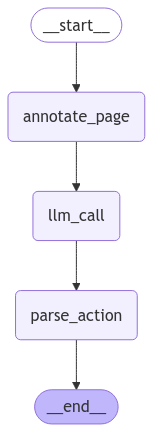

In [80]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

builder = StateGraph(AgentState)

builder.add_node("annotate_page", annotate_page)
builder.add_node("llm_call", llm_call_node)
builder.add_node("parse_action", parse_action_node)

builder.add_edge(START, "annotate_page")
builder.add_edge("annotate_page", "llm_call")
builder.add_edge("llm_call", "parse_action")
builder.add_edge("parse_action", END)

sub_agent_graph = builder.compile()

display(Image(sub_agent_graph.get_graph().draw_mermaid_png()))


In [ ]:
result = await setup_browser("https://arxiv.org/pdf/1706.03762")
playwright, browser, page = result


In [ ]:
input = "Scroll through the pdf and find the section on the Transformer architecture"

state = AgentState(page=page, input=input)

result = await sub_agent_graph.ainvoke(state)
result

In [118]:
result

{'input': 'Look for the actual Attention is all you need paper and write a concise summary on it',
 'page': <Page url='https://arxiv.org/pdf/1706.03762'>,
 'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAKBueIx4ZKCMgoy0qqC+8P//8Nzc8P//////////////////////////////////////////////////////////wgALCACpASwBAREA/8QAFgABAQEAAAAAAAAAAAAAAAAAAAEC/9oACAEBAAAAAcgoARQAAJrWJrYAZyAAAmtYmtpYWVnIAACLGtoBWcgAAJblrYAZyAAAluWtoWWVnIAACLGtoLFZyAAAluWthKGcgAAJblrYShnIAACLGtoBWcgAAJbFpApIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD//EABsQAAIDAQEBAAAAAAAAAAAAAAERADBAEFCA/9oACAEBAAEFAvHHDwWHMOHgsOd9Fh1Cw6hYdQsOoWHULDqFh1uOOOOOOOOOP64//8QAFBABAAAAAAAAAAAAAAAAAAAAkP/aAAgBAQAGPwJRP//EACAQAAEEAgIDAQAAAAAAAAAAAAEAEBExUFEhgSAwQID/2gAIAQEAAT8h8oOlB0oOlB0oOlB0oOlB0oOlB0oOvns1mtgt2s1sFBhSR5az8rtdrtdrtc/TDG2tgoY36UtP1Ye2Ci2N4RDFrYKFGFQpcGPYAAmf1v8A/9oACAEBAAAAEEQAYAAAcAAAAAvLoAAAHzGAAAA8AAAAAPOoAAAFz2AAAA8EAAAAHBAAAAHyCAAACBfYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

# Tools
1. Click (at labelled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)



In [98]:
result["action"]["action"].split("[")[1].split("]")[0]

'6'

In [104]:
result["action"]


{'action': 'Type [6]', 'args': 'Attention is all you need paper'}

### Click

In [100]:
async def click(state: AgentState):
    page = state["page"]
    action = state["action"]
    bbox_id = int(action["action"].split("[")[1].split("]")[0])
    if bbox_id not in [bbox["id"] for bbox in state["bboxes"]]:
        return {"action": "retry", "args": f"Could not find bbox with id {bbox_id}"}
    bbox = state["bboxes"][bbox_id]
    await page.mouse.click(bbox["x"], bbox["y"])
    return f"clicked on {bbox_id}"

result = await click(result)
result
    

'clicked on 6'

### Type


In [115]:
import platform

async def type(state: AgentState):
    page = state["page"]
    action = state["action"]
    bbox_id = int(action["action"].split("[")[1].split("]")[0])
    if bbox_id not in [bbox["id"] for bbox in state["bboxes"]]:
        return {"action": "retry", "args": f"Could not find bbox with id {bbox_id}"}
    bbox = state["bboxes"][bbox_id]
    await page.mouse.click(bbox["x"], bbox["y"])
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(action["args"])
    return f"typed {action['args']} into {bbox_id}"

result = await type(result)
result

'typed Attention is all you need paper into 6'